In [95]:
#Dependencies:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.stats import linregress
import time
import json
import os
from pathlib import Path
import hvplot.pandas
import contextily as ctx

#Files to load
airline_data_to_load = Path("Resources/airlines.csv")
airport_data_to_load = Path("Resources/airports.csv")
flights_data_to_load = Path("Resources/flights.csv")

#Read the data and store it in a Pandas dataframe
airline_data = pd.read_csv(airline_data_to_load)
airport_data = pd.read_csv(airport_data_to_load)
flights_data = pd.read_csv(flights_data_to_load)

#Clean the data to have same column names
airline_data.rename(columns={"AIRLINE": "AIRLINE_NAME"}, inplace=True)
airline_data.rename(columns={"IATA_CODE": "AIRLINE"}, inplace=True)
airport_data.rename(columns={"IATA_CODE": "ORIGIN_AIRPORT"}, inplace=True)

#Combine the data into a single dataframe
flight_data_complete = pd.merge(flights_data, airline_data, on="AIRLINE", how="left")
flight_data_complete = pd.merge(flight_data_complete, airport_data, on="ORIGIN_AIRPORT", how="left")
flight_data_complete

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2015,3,10,2,EV,4122,N11191,RDU,EWR,1013,1005.0,-8.0,17.0,1022.0,96.0,88.0,64.0,416,1126.0,7.0,1149,1133.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Raleigh-Durham International Airport,Raleigh,NC,USA,35.87764,-78.78747
1048571,2015,3,10,2,UA,1018,N79279,LGA,IAH,1013,1005.0,-8.0,40.0,1045.0,264.0,270.0,219.0,1416,1324.0,11.0,1337,1335.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
1048572,2015,3,10,2,UA,1260,N76508,SAN,ORD,1013,1010.0,-3.0,21.0,1031.0,251.0,257.0,220.0,1723,1611.0,16.0,1624,1627.0,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,United Air Lines Inc.,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966
1048573,2015,3,10,2,EV,4349,N14158,MSY,ORD,1013,1003.0,-10.0,10.0,1013.0,149.0,146.0,127.0,837,1220.0,9.0,1242,1229.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Louis Armstrong New Orleans International Airport,New Orleans,LA,USA,29.99339,-90.25803


#  Data cleaning and DF containing merged Resources

In [96]:
#Clean the data and fill the missing values with 0
flight_data_cleaned=flight_data_complete.fillna("0")
flight_data_cleaned

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,0,0,0,0,0,0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,0,0,0,0,0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,0,0,0,0,0,0,US Airways Inc.,San Francisco International Airport,San Francisco,CA,USA,37.619,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,0,0,0,0,0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,0,0,0,0,0,0,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2015,3,10,2,EV,4122,N11191,RDU,EWR,1013,1005.0,-8.0,17.0,1022.0,96.0,88.0,64.0,416,1126.0,7.0,1149,1133.0,-16.0,0,0,0,0,0,0,0,0,Atlantic Southeast Airlines,Raleigh-Durham International Airport,Raleigh,NC,USA,35.87764,-78.78747
1048571,2015,3,10,2,UA,1018,N79279,LGA,IAH,1013,1005.0,-8.0,40.0,1045.0,264.0,270.0,219.0,1416,1324.0,11.0,1337,1335.0,-2.0,0,0,0,0,0,0,0,0,United Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
1048572,2015,3,10,2,UA,1260,N76508,SAN,ORD,1013,1010.0,-3.0,21.0,1031.0,251.0,257.0,220.0,1723,1611.0,16.0,1624,1627.0,3.0,0,0,0,0,0,0,0,0,United Air Lines Inc.,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966
1048573,2015,3,10,2,EV,4349,N14158,MSY,ORD,1013,1003.0,-10.0,10.0,1013.0,149.0,146.0,127.0,837,1220.0,9.0,1242,1229.0,-13.0,0,0,0,0,0,0,0,0,Atlantic Southeast Airlines,Louis Armstrong New Orleans International Airport,New Orleans,LA,USA,29.99339,-90.25803


In [97]:
#Check to insure there are no null values
null_count= flight_data_cleaned.isnull().sum()
null_count

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
AIRLINE_NAME           0
AIRPORT                0
CITY                   0
STATE                  0
COUNTRY                0
LATITUDE               0
LONGITUDE              0
dtype: int64

In [98]:
#What is the average delay time for each airline

#Create a new dataframe that contains the airline delays that are greater than zero
flight_data_cleaned['AIRLINE_DELAY'] = flight_data_cleaned['AIRLINE_DELAY'].astype(float)
flights_delayed_df = flight_data_cleaned.loc[flight_data_cleaned['AIRLINE_DELAY'] > 0]
flights_delayed_df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,145.0,0.0,16.0,201.0,370.0,385.0,361.0,2762,602.0,8.0,555,610.0,15.0,0,0,0,0.0,0.0,15.0,0.0,0.0,Hawaiian Airlines Inc.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
52,2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,535.0,95.0,9.0,544.0,185.0,175.0,163.0,1189,727.0,3.0,605,730.0,85.0,0,0,0,0.0,0.0,85.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
55,2015,1,1,4,B6,2276,N646JB,SJU,BDL,438,550.0,72.0,15.0,605.0,241.0,258.0,237.0,1666,902.0,6.0,739,908.0,89.0,0,0,0,17.0,0.0,72.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
73,2015,1,1,4,US,425,N174US,PDX,PHX,520,620.0,60.0,13.0,633.0,150.0,150.0,132.0,1009,945.0,5.0,850,950.0,60.0,0,0,0,0.0,0.0,60.0,0.0,0.0,US Airways Inc.,Portland International Airport,Portland,OR,USA,45.58872,-122.5975
74,2015,1,1,4,AA,89,N3KVAA,IAH,MIA,520,618.0,58.0,19.0,637.0,141.0,137.0,111.0,964,928.0,7.0,841,935.0,54.0,0,0,0,0.0,0.0,54.0,0.0,0.0,American Airlines Inc.,George Bush Intercontinental Airport,Houston,TX,USA,29.98047,-95.33972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048534,2015,3,10,2,WN,449,N8603F,BWI,ISP,1010,1210.0,120.0,9.0,1219.0,65.0,57.0,42.0,220,1301.0,6.0,1115,1307.0,112.0,0,0,0,0.0,0.0,112.0,0.0,0.0,Southwest Airlines Co.,Baltimore-Washington International Airport,Baltimore,MD,USA,39.1754,-76.6682
1048540,2015,3,10,2,EV,4878,N686BR,DTW,BTV,1010,1138.0,88.0,12.0,1150.0,105.0,81.0,66.0,537,1256.0,3.0,1155,1259.0,64.0,0,0,0,0.0,0.0,7.0,57.0,0.0,Atlantic Southeast Airlines,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
1048543,2015,3,10,2,EV,2509,N901EV,DFW,GGG,1010,1106.0,56.0,17.0,1123.0,47.0,53.0,33.0,140,1156.0,3.0,1057,1159.0,62.0,0,0,0,6.0,0.0,35.0,21.0,0.0,Atlantic Southeast Airlines,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.0372
1048559,2015,3,10,2,OO,6300,N564SW,LAX,PSP,1011,1043.0,32.0,28.0,1111.0,63.0,73.0,36.0,110,1147.0,9.0,1114,1156.0,42.0,0,0,0,10.0,0.0,7.0,25.0,0.0,Skywest Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [99]:
#View all columns in the dataframe 

pd.set_option('display.max_columns', None)
print(flights_delayed_df)

         YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
35       2015      1    1            4      HA             17      N389HA   
52       2015      1    1            4      B6           2134      N307JB   
55       2015      1    1            4      B6           2276      N646JB   
73       2015      1    1            4      US            425      N174US   
74       2015      1    1            4      AA             89      N3KVAA   
...       ...    ...  ...          ...     ...            ...         ...   
1048534  2015      3   10            2      WN            449      N8603F   
1048540  2015      3   10            2      EV           4878      N686BR   
1048543  2015      3   10            2      EV           2509      N901EV   
1048559  2015      3   10            2      OO           6300      N564SW   
1048561  2015      3   10            2      DL           1117      N586NW   

        ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  \
35      

# First statistical analysis for Airlines

In [100]:
#How many total delays are there for each month of the year?

month_df=flights_delayed_df.groupby("MONTH")[["AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].sum(numeric_only=True)
month_df

,AIRLINE_DELAY
MONTH,
1,1708155.0
2,1712660.0
3,739212.0


In [101]:
#What are the types of delays?

delay_df= flights_delayed_df[["AIR_SYSTEM_DELAY", "SECURITY_DELAY",  "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]]
delay_df

,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
35,0.0,0.0,15.0,0.0,0.0
52,0.0,0.0,85.0,0.0,0.0
55,17.0,0.0,72.0,0.0,0.0
73,0.0,0.0,60.0,0.0,0.0
74,0.0,0.0,54.0,0.0,0.0
...,...,...,...,...,...
1048534,0.0,0.0,112.0,0.0,0.0
1048540,0.0,0.0,7.0,57.0,0.0
1048543,6.0,0.0,35.0,21.0,0.0
1048559,10.0,0.0,7.0,25.0,0.0


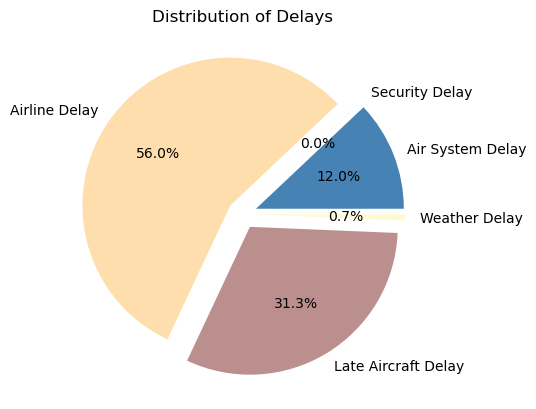

In [102]:
# Calculate the total sum of delays
total_delays = delay_df.sum()

# Create pie chart
labels = ["Air System Delay", "Security Delay", "Airline Delay", "Late Aircraft Delay", "Weather Delay"]
values = total_delays.values
colors = ["steelblue", "powderblue", "navajowhite", "rosybrown", "lemonchiffon"]
explode = [0.1, 0.1, 0.1, 0.1, 0.1] 
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('Distribution of Delays')
plt.show()

In [103]:
airsystem_delay= delay_df["AIR_SYSTEM_DELAY"].sum()
airsystem_delay

894796.0

In [104]:
#What is the average delay time for each airline

#Find the average delay time for each airline using groupby 
average_delay= flights_delayed_df.groupby(["AIRLINE"])["AIRLINE_DELAY"].mean()
average_delay_df=pd.DataFrame(average_delay)
average_df = average_delay_df.reset_index().sort_values(['AIRLINE_DELAY'],ascending=False)
average_df

,AIRLINE,AIRLINE_DELAY
9,OO,48.764726
1,AS,43.373053
0,AA,41.479850
3,DL,40.594448
4,EV,40.368104
7,MQ,35.969413
10,UA,32.694872
12,VX,32.045394
11,US,31.668644
5,F9,30.235959


Text(0, 0.5, 'sum. delay in minutes')

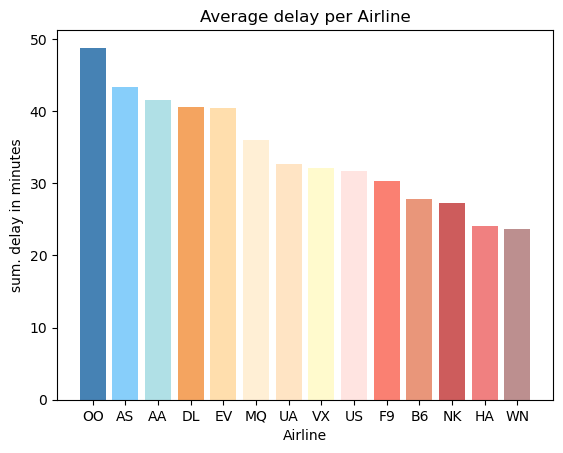

In [105]:
#Graph for average delay for each airline

colors = ["steelblue", "lightskyblue", "powderblue", "sandybrown", "navajowhite", "papayawhip", "bisque", "lemonchiffon", "mistyrose", "salmon", "darksalmon", "indianred", "lightcoral","rosybrown"]
plt.bar(average_df['AIRLINE'], average_df['AIRLINE_DELAY'], color=colors)
plt.title("Average delay per Airline")
plt.xlabel("Airline")
plt.ylabel("sum. delay in minutes")

# Second statistical analysis on Origin Airports

In [106]:
#Find the average delay of each origin airport

origin_delay= flights_delayed_df.groupby(["ORIGIN_AIRPORT"])["AIRLINE_DELAY"].mean()
origin_delay

ORIGIN_AIRPORT
ABE     44.659574
ABI     42.545455
ABQ     36.420455
ABR    300.500000
ABY     50.421053
          ...    
VLD     46.222222
VPS     62.692308
WRG     15.666667
XNA     61.433155
YUM    102.818182
Name: AIRLINE_DELAY, Length: 308, dtype: float64

In [107]:
origin_delay.describe()

count    308.000000
mean      54.561022
std       47.130055
min        1.000000
25%       31.863103
50%       40.619036
75%       57.302500
max      359.500000
Name: AIRLINE_DELAY, dtype: float64

In [108]:
#What origin airport has the highest amount of delayed flights

max_origin_delay = flights_delayed_df.groupby("ORIGIN_AIRPORT")["AIRLINE_DELAY"].max()
max_delay = max_origin_delay.max()
origin_airport_with_max_delay = max_origin_delay.idxmax()
print(f"The origin airport with the maximum delay is {origin_airport_with_max_delay} with a delay of {max_delay}")

The origin airport with the maximum delay is BHM with a delay of 1971.0


# Third Statistical Analysis on Destination airport

In [109]:
#Find the average delay of each destination airport

destination_delay= flights_delayed_df.groupby(["DESTINATION_AIRPORT"])["AIRLINE_DELAY"].mean()
destination_delay

DESTINATION_AIRPORT
ABE    43.913043
ABI    29.146341
ABQ    24.764228
ABR    37.750000
ABY    53.041667
         ...    
VPS    37.397959
WRG    16.000000
XNA    36.401961
YAK    10.500000
YUM    46.842105
Name: AIRLINE_DELAY, Length: 314, dtype: float64

In [110]:
#What destination airport has the highest amount of delayed flights

max_destination_delay = flights_delayed_df.groupby("DESTINATION_AIRPORT")["AIRLINE_DELAY"].max()
max_delay = max_origin_delay.max()
destination_airport_with_max_delay = max_destination_delay.idxmax()
print(f"The destination airport with the maximum delay is {destination_airport_with_max_delay} with a delay of {max_delay}")

The destination airport with the maximum delay is DFW with a delay of 1971.0


# Fourth statistical analysis on all airports

In [111]:
# convert data to numeric values

flight_data_cleaned['AIRLINE_DELAY'] = pd.to_numeric(flight_data_cleaned['AIRLINE_DELAY'], errors='coerce')
flight_data_cleaned['AIR_SYSTEM_DELAY'] = pd.to_numeric(flight_data_cleaned['AIR_SYSTEM_DELAY'], errors='coerce')
flight_data_cleaned['SECURITY_DELAY'] = pd.to_numeric(flight_data_cleaned['SECURITY_DELAY'], errors='coerce')
flight_data_cleaned['LATE_AIRCRAFT_DELAY'] = pd.to_numeric(flight_data_cleaned['LATE_AIRCRAFT_DELAY'], errors='coerce')
flight_data_cleaned['WEATHER_DELAY'] = pd.to_numeric(flight_data_cleaned['WEATHER_DELAY'], errors='coerce')

In [112]:
# crete new df where delay is > 1
flights_all_delayed_df= flight_data_cleaned[(flight_data_cleaned['AIRLINE_DELAY'] > 1) |
                  (flight_data_cleaned['AIR_SYSTEM_DELAY'] > 1) |
                  (flight_data_cleaned['SECURITY_DELAY'] > 1) |
                  (flight_data_cleaned['LATE_AIRCRAFT_DELAY'] > 1) |
                  (flight_data_cleaned['WEATHER_DELAY'] > 1)]
flights_all_delayed_df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
27,2015,1,1,4,NK,597,N528NK,MSP,FLL,115,127.0,12.0,14.0,141.0,207.0,220.0,166.0,1487,527.0,40.0,542,607.0,25.0,0,0,0,25.0,0.0,0.0,0.0,0.0,Spirit Air Lines,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692
30,2015,1,1,4,NK,168,N629NK,PHX,ORD,125,237.0,72.0,9.0,246.0,204.0,175.0,156.0,1440,622.0,10.0,549,632.0,43.0,0,0,0,43.0,0.0,0.0,0.0,0.0,Spirit Air Lines,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,145.0,0.0,16.0,201.0,370.0,385.0,361.0,2762,602.0,8.0,555,610.0,15.0,0,0,0,0.0,0.0,15.0,0.0,0.0,Hawaiian Airlines Inc.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
50,2015,1,1,4,B6,1030,N239JB,BQN,MCO,307,304.0,-3.0,25.0,329.0,173.0,196.0,160.0,1129,509.0,11.0,500,520.0,20.0,0,0,0,20.0,0.0,0.0,0.0,0.0,JetBlue Airways,Rafael Hernández Airport,Aguadilla,PR,USA,18.49486,-67.12944
52,2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,535.0,95.0,9.0,544.0,185.0,175.0,163.0,1189,727.0,3.0,605,730.0,85.0,0,0,0,0.0,0.0,85.0,0.0,0.0,JetBlue Airways,Luis Muñoz Marín International Airport,San Juan,PR,USA,18.43942,-66.00183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048543,2015,3,10,2,EV,2509,N901EV,DFW,GGG,1010,1106.0,56.0,17.0,1123.0,47.0,53.0,33.0,140,1156.0,3.0,1057,1159.0,62.0,0,0,0,6.0,0.0,35.0,21.0,0.0,Atlantic Southeast Airlines,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.0372
1048552,2015,3,10,2,OO,6249,N771SK,LAS,SFO,1010,1109.0,59.0,12.0,1121.0,103.0,91.0,75.0,414,1236.0,4.0,1153,1240.0,47.0,0,0,0,47.0,0.0,0.0,0.0,0.0,Skywest Airlines Inc.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
1048559,2015,3,10,2,OO,6300,N564SW,LAX,PSP,1011,1043.0,32.0,28.0,1111.0,63.0,73.0,36.0,110,1147.0,9.0,1114,1156.0,42.0,0,0,0,10.0,0.0,7.0,25.0,0.0,Skywest Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
1048561,2015,3,10,2,DL,1117,N586NW,MSP,RSW,1012,1047.0,35.0,9.0,1056.0,202.0,183.0,169.0,1416,1445.0,5.0,1434,1450.0,16.0,0,0,0,0.0,0.0,16.0,0.0,0.0,Delta Air Lines Inc.,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692


In [113]:
#What is the sum delay time for each airport for each of the five delays

sum_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["AIRLINE_DELAY"].sum()
sum_air_system_delay= flights_all_delayed_df.groupby(["AIRPORT"])['AIR_SYSTEM_DELAY'].sum()
sum_security_delay= flights_all_delayed_df.groupby(["AIRPORT"])["SECURITY_DELAY"].sum()
sum_late_airline_delay= flights_all_delayed_df.groupby(["AIRPORT"])["LATE_AIRCRAFT_DELAY"].sum()
sum_weather_delay= flights_all_delayed_df.groupby(["AIRPORT"])["WEATHER_DELAY"].sum()

In [114]:
flights_delay_sum = pd.DataFrame({
                                    "Airline Delay Sum": sum_airline_delay,
                                    "Air System Delay Sum": sum_air_system_delay,
                                    "Security Delay Sum": sum_security_delay,
                                    "Late Aircraft Delay Sum": sum_late_airline_delay,
                                    "Weather Delay Sum": sum_weather_delay
})

In [115]:
# Create a df for the sum of the delays by each individual airport

delay_sums = flights_delay_sum.groupby('AIRPORT')[['Airline Delay Sum', 'Air System Delay Sum', 'Security Delay Sum', 'Late Aircraft Delay Sum', 'Weather Delay Sum']].sum()
delay_sums['TOTAL DELAYS (minutes)'] = delay_sums[['Airline Delay Sum', 'Air System Delay Sum', 'Security Delay Sum', 'Late Aircraft Delay Sum', 'Weather Delay Sum']].sum(axis=1)
delay_sums_df = pd.DataFrame(delay_sums ['TOTAL DELAYS (minutes)'])
delay_sums_df

,TOTAL DELAYS (minutes)
AIRPORT,
Aberdeen Regional Airport,3616.0
Abilene Regional Airport,6927.0
Abraham Lincoln Capital Airport,5039.0
Adak Airport,181.0
Akron-Canton Regional Airport,12304.0
...,...
Yakutat Airport,750.0
Yampa Valley Airport (Yampa Valley Regional),6853.0
Yeager Airport,8829.0


In [116]:
high_airport=delay_sums_df.sort_values(by = "TOTAL DELAYS (minutes)", axis=0,ascending=False).head(5)
high_airport['Airport'] = high_airport.index
high_airport

,TOTAL DELAYS (minutes),Airport
AIRPORT,,
Chicago O'Hare International Airport,1085917.0,Chicago O'Hare International Airport
Dallas/Fort Worth International Airport,724981.0,Dallas/Fort Worth International Airport
Denver International Airport,597121.0,Denver International Airport
Hartsfield-Jackson Atlanta International Airport,596270.0,Hartsfield-Jackson Atlanta International Airport
LaGuardia Airport (Marine Air Terminal),415656.0,LaGuardia Airport (Marine Air Terminal)


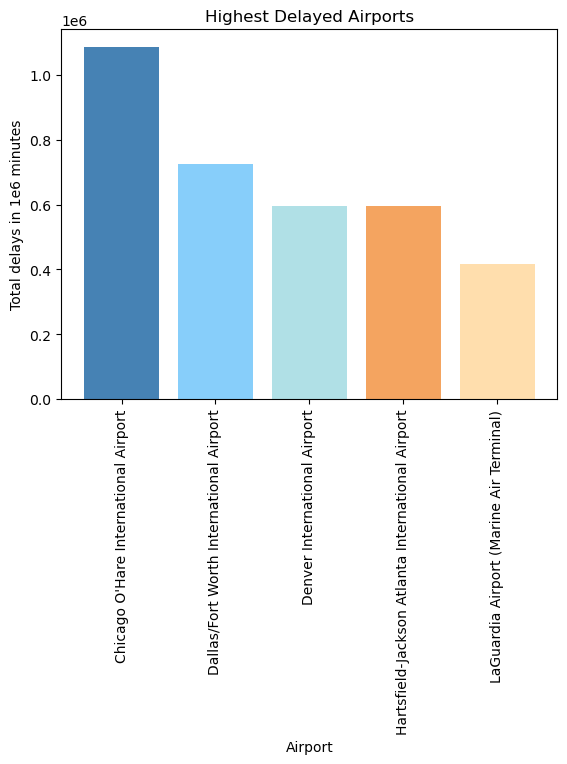

In [147]:
#Create a chart for the highest delayed airports
colors = ["steelblue", "lightskyblue", "powderblue", "sandybrown", "navajowhite"] 
plt.bar(high_airport["Airport"], high_airport["TOTAL DELAYS (minutes)"], color=colors)
plt.title("Highest Delayed Airports")
plt.xlabel("Airport")
plt.ylabel("Total delays in 1e6 minutes")
plt.xticks(rotation=90)
plt.show()

In [118]:
#Find the top 5 airports with the lowest number of total delays 
low_airport= delay_sums_df.sort_values(by = "TOTAL DELAYS (minutes)", axis=0,ascending=True).head(5)
low_airport['Airport'] = low_airport.index
low_airport

,TOTAL DELAYS (minutes),Airport
AIRPORT,,
Bert Mooney Airport,45.0,Bert Mooney Airport
Ithaca Tompkins Regional Airport,46.0,Ithaca Tompkins Regional Airport
Canyonlands Field,124.0,Canyonlands Field
Adak Airport,181.0,Adak Airport
Magic Valley Regional Airport (Joslin Field),186.0,Magic Valley Regional Airport (Joslin Field)


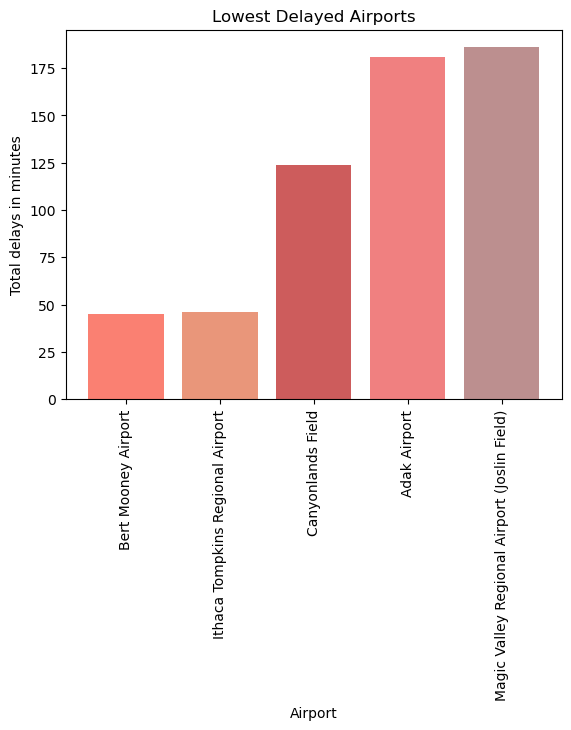

In [119]:
#Create a chart for the lowest delayed airports
colors = ["salmon", "darksalmon", "indianred", "lightcoral","rosybrown"] 
plt.bar(low_airport["Airport"], low_airport["TOTAL DELAYS (minutes)"], color=colors)
plt.title("Lowest Delayed Airports")
plt.xlabel("Airport")
plt.ylabel("Total delays in minutes")
plt.xticks(rotation=90)
plt.show()

In [120]:
#Find the coordinates for the best and worst airports

# == airport intials then return the lat and long 
# then using those coordinates, make a map 
#need to use a zip and maybe an empty list 

## Weather Delay for each airline

In [146]:
weather_delay_by_airline = flights_delayed_df.groupby(['MONTH'])['WEATHER_DELAY'].sum()
# Print the weather delay for each airline per month
for (month), delay in weather_delay_by_airline.items():
    print(f"Month: {month}, Weather Delay: {delay}")

Month: 1, Weather Delay: 16928.0
Month: 2, Weather Delay: 24107.0
Month: 3, Weather Delay: 8274.0


# Plotting worst airports by lon and lat

In [141]:
# Create empty lists to store latitude and longitude
latitudes = []
longitudes = []
airports = []
# Create empty sets to store unique airports
processed_airports = set()
# Iterate through the DataFrame
for index, row in flights_all_delayed_df.iterrows():
    airport = row['AIRPORT']
    if airport == "Chicago O'Hare International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at CHI is {latitude},{longitude}")
        # Store latitude and longitude in the lists
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)  # Add airport to the set of processed airports
    elif airport == "Dallas/Fort Worth International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at DFX is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "Denver International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at DEN is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "Hartsfield-Jackson Atlanta International Airport" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at ATL is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)
    elif airport == "LaGuardia Airport (Marine Air Terminal)" and airport not in processed_airports:
        latitude = row['LATITUDE']
        longitude = row['LONGITUDE']
        print(f"The Lat , Lon at LGA is {latitude},{longitude}")
        latitudes.append(latitude)
        longitudes.append(longitude)
        processed_airports.add(airport)

The Lat , Lon at DFX is 32.89595,-97.0372
The Lat , Lon at DEN is 39.85841,-104.667
The Lat , Lon at CHI is 41.9796,-87.90446
The Lat , Lon at LGA is 40.77724,-73.87261
The Lat , Lon at ATL is 33.64044,-84.42694


In [142]:
airport_df_coord = pd.DataFrame({"processed_airports": ["DFX", "DEN", "CHI", "LGA", "ATL"]})


,processed_airports
0,DFX
1,DEN
2,CHI
3,LGA
4,ATL


In [143]:
airport_df_coord = pd.DataFrame({"processed_airports": ["DFX", "DEN", "CHI", "LGA", "ATL"]})
# Add latitude and longitude values
airport_df_coord.loc[0, "latitude"] = 32.89595
airport_df_coord.loc[0, "longitude"] = -97.0372
airport_df_coord.loc[1, "latitude"] = 39.85841
airport_df_coord.loc[1, "longitude"] = -104.667
airport_df_coord.loc[2, "latitude"] = 41.9796
airport_df_coord.loc[2, "longitude"] = -87.90446
airport_df_coord.loc[3, "latitude"] = 33.64044
airport_df_coord.loc[3, "longitude"] = -84.42694
airport_df_coord.loc[4, "latitude"] = 33.94254
airport_df_coord.loc[4, "longitude"] = -118.40807
airport_df_coord

,processed_airports,latitude,longitude
0,DFX,32.89595,-97.03720
1,DEN,39.85841,-104.66700
2,CHI,41.97960,-87.90446
3,LGA,33.64044,-84.42694
4,ATL,33.94254,-118.40807


In [144]:
import pandas as pd

# Create the airport_df_coord DataFrame using latitudes and longitudes
airport_df_coord = pd.DataFrame({
    'processed_airports': ['DFX', 'DEN', 'CHI', 'LGA', 'ATL'],
    'latitude': latitudes,
    'longitude': longitudes
})
airport_df_coord

,processed_airports,latitude,longitude
0,DFX,32.89595,-97.03720
1,DEN,39.85841,-104.66700
2,CHI,41.97960,-87.90446
3,LGA,40.77724,-73.87261
4,ATL,33.64044,-84.42694


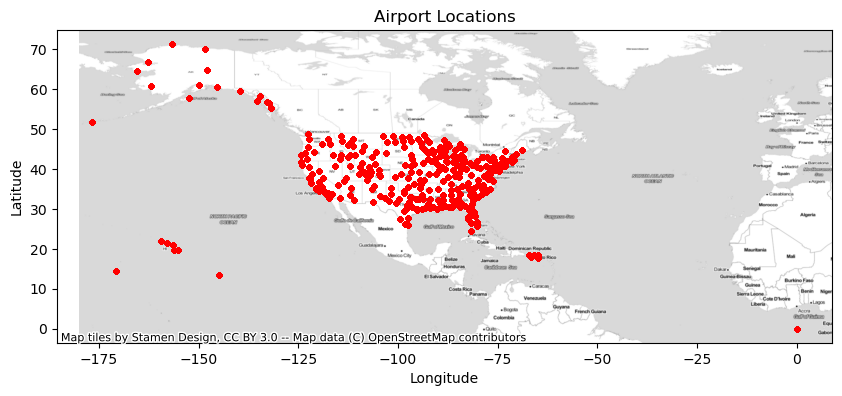

In [126]:
flight_data_cleaned['LONGITUDE'] = flight_data_cleaned['LONGITUDE'].astype(float)
flight_data_cleaned['LATITUDE'] = flight_data_cleaned['LATITUDE'].astype(float)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(flight_data_cleaned['LONGITUDE'], flight_data_cleaned['LATITUDE'], color='red', s=10)

# Add map tiles
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Customize the map
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airport Locations')

# Show the map
plt.show()

In [130]:

# Create empty lists to store latitude and longitude
latitudes = []
longitudes = []
# Iterate through the DataFrame
for index, row in flight_data_cleaned.iterrows():
    # Get the airport's name
    airport_name = row["AIRPORT"]
    # Check if the airport is one of the five specified airports
    if airport_name in ["Chicago O'Hare International Airport",
                        "Dallas/Fort Worth International Airport",
                        "Denver International Airport",
                        "Hartsfield-Jackson Atlanta International Airport",
                        "LaGuardia Airport (Marine Air Terminal)"]:
        # Get latitude and longitude from the DataFrame
        latitude = row["LATITUDE"]
        longitude = row["LONGITUDE"]
        # Add latitude and longitude to the lists
        latitudes.append(latitude)
        longitudes.append(longitude)

In [145]:
map_plot_2 = airport_df_coord.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="OSM",
    frame_width=800,
    frame_height=600,
    scale=1,
    size = 125,
    color="processed_airports"
)
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (processed_airports)